In [1]:
from sqlalchemy import create_engine 
import geopandas as gpd
from shapely.ops import nearest_points

# Create Database Connection

In [2]:
DATABASE_TYPE="postgresql"
USERNAME="adminff"
PASSWORD="ffmodeling"
HOST="localhost"
PORT=5433
DATABASE_NAME="ff"
TABLE_NAME="division_station"

In [3]:
engine = create_engine(f"{DATABASE_TYPE}://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE_NAME}")

## Database Constants

In [4]:
ICS_META_TABLE_NAME="ics"
SUBDIVISION_TABLE_NAME="subdivision_data"

In [5]:
subdivision_query = """select sd.cid, sd.geometry from subdivision_dataset sd"""
ics_mata_query = """select im."climate_ID", im.prov, im.geometry  from ics_meta im"""

# Read station and division data

In [6]:
division_df = gpd.read_postgis(
    sql=subdivision_query, 
    con=engine,
    geom_col="geometry",
    crs="EPSG:4326",)  
# division_ddf = dgpd.from_geopandas(division_df, npartitions=N_PARTISIONS)
# del division_df

In [7]:
ics_meta_df = gpd.read_postgis(
    sql=ics_mata_query, 
    con=engine,
    geom_col="geometry",
    crs="EPSG:4326",)  
# ics_meta_ddf = dgpd.from_geopandas(ics_meta_df, npartitions=N_PARTISIONS)
# del ics_meta_df

# Find all the staions in division

In [8]:
stations_in_subdivision = gpd.sjoin(
    ics_meta_df,
    division_df,
    how="inner",
    predicate="within").drop("index_right", axis=1)

In [9]:
stations_in_subdivision

,climate_ID,prov,geometry,cid
0,3010010,AB,POINT (-112.97000 54.28000),4
1,3010237,AB,POINT (-112.28000 53.92000),4
2,3060406,AB,POINT (-112.82000 54.78000),4
33,3012275,AB,POINT (-112.87000 53.68000),4
56,3013959,AB,POINT (-110.07000 53.31000),4
...,...,...,...,...
559,2100805,YT,POINT (-139.84000 67.57000),0
560,2100935,YT,POINT (-136.22000 66.98000),0
561,2101102,YT,POINT (-132.73000 60.17000),0
562,2101201,YT,POINT (-128.82000 60.12000),0


In [10]:
stations_in_subdivision[['cid','climate_ID']].to_sql(name=TABLE_NAME, con=engine, if_exists='replace', index=False)

510

In [11]:
stations_in_subdivision = stations_in_subdivision.groupby("cid").agg(lambda group: set(group))

<Axes: ylabel='Frequency'>

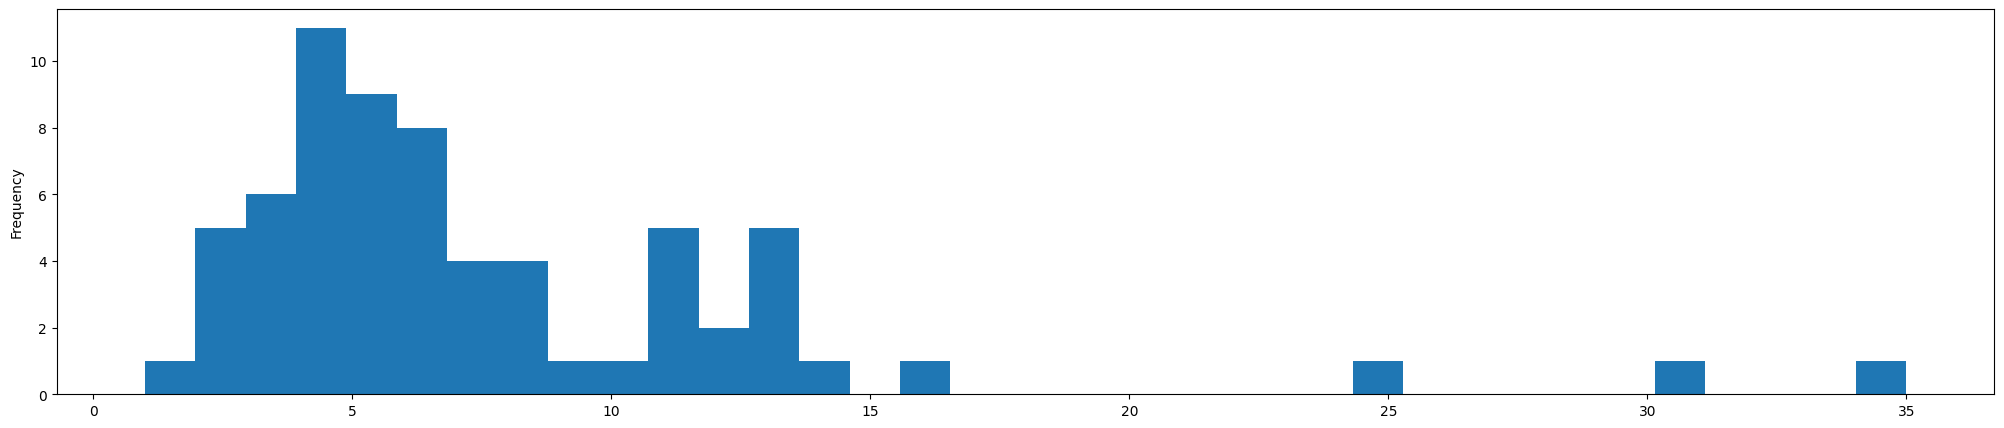

In [12]:
stations_in_subdivision.apply(lambda row: len(row.climate_ID), axis=1).plot(kind='hist',bins=35,figsize=(25, 5))

In [13]:
divisions_with_station = stations_in_subdivision.index.to_list()
print(f"stations found {len(divisions_with_station)}")

stations found 67


# Find the nearest station for division woth no stations

In [14]:
division_with_no_stations = division_df[~division_df["cid"].isin(divisions_with_station)]
division_with_no_stations

,cid,geometry


# if found divisions with no stations run below code 

In [15]:
def get_nearest_station_id(division):
    divison_id = division.FEDUID
    division_geomaetry = division.geometry
    _, nearest_point = nearest_points(division_geomaetry.centroid, ics_meta_df.geometry.unary_union)
    station_id = ics_meta_df.loc[ics_meta_df['geometry'] == nearest_point].climate_ID.values[0]
    return station_id

In [16]:
# division_with_no_stations['climate_ID'] = division_with_no_stations.apply(get_nearest_station_id, axis=1)

In [17]:
# division_with_no_stations[['FEDUID','climate_ID']].to_sql(name=TABLE_NAME, con=engine, if_exists='append', index=False)

# Add Primary Key to Table

In [19]:
with engine.connect() as con:
    con.execute('ALTER TABLE division_station ADD PRIMARY KEY ("cid", "climate_ID");')